# Kernel herding examples
The aim of this notebook is to provide simple examples to apply kernel herding on multivariate random inputs with or without a dependency structure.

In [1]:
%matplotlib inline

In [2]:
import openturns as ot
import otkerneldesign as otkd
from plotools import *
from matplotlib import rc, rcParams, style
style.use('default')
rcParams['text.usetex'] = True
#rcParams['text.latex.unicode'] = True
rc('font', **{'family': 'Palatino'})
rc('text', usetex=True)
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=14)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size
#rc('figure', titlesize='xx-large')# Set the font size of the figure title

## Independent bivariate random mixture

In [3]:
# Random input variable definition
# Here a random mixture
modes = [ot.Normal(0.3, 0.12), ot.Normal(0.7, 0.1)]
weight = [0.4, 1.0]
mixture = ot.Mixture(modes, weight)
normal = ot.Normal(0.6, 0.15)
distribution = ot.ComposedDistribution([mixture, normal])

## Dependent bivariate random mixture
Using the same example, we can add a Copula as a dependency structure. Note that the KernelHerdingTensorized class cannot be used in this case. 

In [4]:
distribution.setCopula(ot.ClaytonCopula(2.))

In [5]:
dimension = distribution.getDimension()
size = 20
# Monte Carlo design
mc_design = distribution.getSample(size)
# Kernel definition
ker_list = [ot.MaternModel([0.1], [1.0], 2.5)] * dimension
kernel = ot.ProductCovarianceModel(ker_list)
# Kernel herding design
kh = otkd.KernelHerding(
    kernel=kernel,
    candidate_set_size=2 ** 12,
    distribution=distribution
)
kh_design, _ = kh.select_design(size)

In [6]:
def compute_bayesian_quadrature_weights(input_sample, candidate_set):
    """
    Compute optimal weights for probabilistic integration using a given sample.

    Parameters
    ----------
        input_sample : :class:`openturns.Sample`
                Sample of points to be optimally weighted.
    """
    # TODO: 
    # Test dimension consistency with init objects 
    size = input_sample.getSize()
    global_sample = ot.Sample(input_sample)
    global_sample.add(candidate_set)
    cov_rows = np.zeros((size, global_sample.getSize()))
    for idx in range(size):
        cov_rows[idx, :] = kernel.discretizeRow(global_sample, int(idx)).asPoint()
    covmatrix = cov_rows[:, :size] + np.identity(size) * 1e-4
    # TODO: 
    # - add a test on the conditioning using np.cond(covmatrix)
    # - try inversion using Pytorch 
    potentials = cov_rows[:, size:].mean(axis=1)
    return np.linalg.solve(covmatrix.T, potentials.T).T

In [7]:
kh_weights = compute_bayesian_quadrature_weights(kh_design, kh._candidate_set)
mc_weights = compute_bayesian_quadrature_weights(mc_design, kh._candidate_set)

In [8]:
d = DrawFunctions()
def draw_candidates(candidate_sample, title='Design of experiments'):
    fig = d.draw_2D_controur('Sampling a bivariate random mixture', None, distribution)
    plt.title(title, fontsize=20)
    plt.xlabel("$x_0$", fontsize=20)
    plt.ylabel("$x_1$", fontsize=20)
    plt.scatter(candidate_sample[:, 0], candidate_sample[:, 1], alpha=0.1, label='candidate points ($N={}$)'.format(len(candidate_sample)), color='C7')
    plt.legend(loc='best')
    return fig

(array([3., 5., 2., 3., 2., 1., 2., 1., 0., 1.]),
 array([0.00066072, 0.01288644, 0.02511215, 0.03733787, 0.04956358,
        0.0617893 , 0.07401501, 0.08624073, 0.09846644, 0.11069216,
        0.12291787]),
 <BarContainer object of 10 artists>)

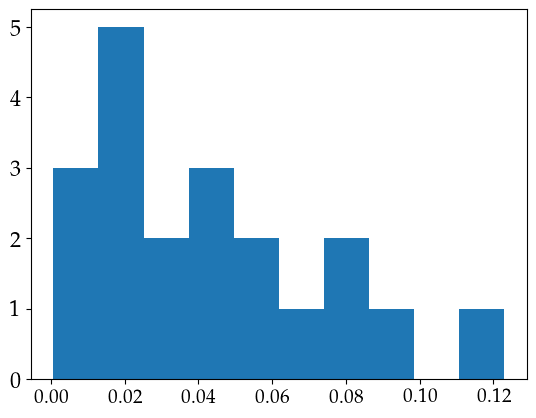

In [9]:
plt.hist(mc_weights)

(array([2., 2., 1., 5., 1., 3., 0., 5., 0., 1.]),
 array([0.02446507, 0.02932218, 0.03417929, 0.03903641, 0.04389352,
        0.04875064, 0.05360775, 0.05846487, 0.06332198, 0.0681791 ,
        0.07303621]),
 <BarContainer object of 10 artists>)

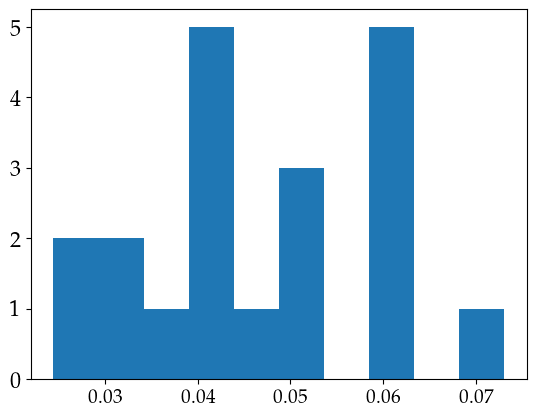

In [10]:
plt.hist(kh_weights)

In [11]:
def draw_2D_design(x_sample, second_sample, x_candidate=None, title_label='Design of experiments', method_label='kernel herding', save_file=None):
    fig = draw_candidates(x_candidate, title_label)
    x_label = '{} sequential design ($n={}$)'.format(method_label, len(x_sample))
    plt.scatter(second_sample[:, 0], second_sample[:, 1], color='C5', label='Monte Carlo design ($n={}$)'.format(len(second_sample)), s=mc_weights * 1500, marker='o')
    plt.scatter(x_sample[:, 0], x_sample[:, 1], color='C0', label=x_label, s=kh_weights * 1500, marker='o')
    for i in range(len(x_sample)):
        plt.text(x_sample[i][0], x_sample[i][1], r"$\textbf{}$".format(i + 1), weight="bold", fontsize=12)
    legend = plt.legend(loc='best', fontsize=12)
    if save_file is not None:
        fig.savefig(save_file, bbox_extra_artists=(legend,), bbox_inches='tight')
    return fig

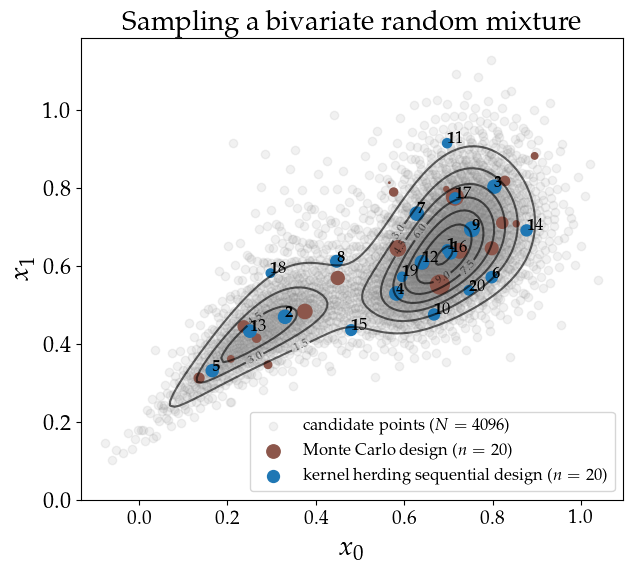

In [12]:
draw_2D_design(kh_design, mc_design, kh._candidate_set, title_label='Sampling a bivariate random mixture', save_file='bivariate_kh.pdf');